In [1]:
import json
import pandas_datareader as pdr
import pandas as pd
import requests
import datetime as dt
import matplotlib.pyplot as plt

HKEX_URL_ROOT = "https://www.hkex.com.hk/eng/stat/dmstat/marksum/YearlyStatistics_O_{}.json"
HKEX_URL_DICT = {
    'HSCE': 'HHI'
}

INDEX_CONTRACT_MULT = 50

USD_HKD_FX = 7.72

SOURCE = 'yahoo'

def parse_header(header_dict):
    columns = []
    column_queue = []
    for element in header_dict:
        if 'colspan' not in element:
            if len(column_queue):
                columns.append('{}-{}'.format(column_queue[0]['text'], element['text']))
                column_queue[0]['colspan'] -= 1
                if column_queue[0]['colspan'] == 0:
                    column_queue.pop(0)
            else:
                columns.append(element['text'])
        else:
            column_queue.append(element)

    return columns


def parse_json(json_data):

    content_dict = json.loads(json_data)
    table = content_dict['tables'][0]
    columns = parse_header(table['header'])
    data = [v['text'] for v in table['body']]

    if len(data) % len(columns) != 0:
        raise ValueError('an error occurred in parsing the columns')

    rows = int(len(data) / len(columns))
    column_length = len(columns)
    table_data = [data[column_length*i:column_length*(i+1)] for i in range(rows)]
    df = pd.DataFrame(table_data, columns=columns)
    df.loc[:, 'Year'] = df.Year.apply(lambda x: x.split(' ')[0]).astype(int)
    df.set_index('Year', drop=True, inplace=True)
    df = df.applymap(lambda x: x.replace(',', '')).astype(float)
    return df


def main(symbol):
    symbol = symbol.upper()
    if symbol not in ['HSI', 'HSCE']:
        raise ValueError("Symbol must be in ['HSI', 'HSCE']")
    url = HKEX_URL_ROOT.format(HKEX_URL_DICT.get(symbol, symbol))
    
    req = requests.get(url)
    content = req.content.decode('utf-8')

    volume_df = parse_json(content)
    start = dt.date(int(volume_df.index[0]), 1, 1)
    end = dt.date.today()
    close_price_data = pdr.data.DataReader('^{}'.format(symbol), SOURCE, start, end)
    average_close = close_price_data.resample('Y').Close.mean()

    average_close.index = [v.year for v in average_close.index]
    average_close.index.name = 'Year'
    average_close.name = '{} average spot'.format(symbol)

    stats_df = volume_df.join(average_close, how='inner')

    stats_df['notional'] = (stats_df['Contract Volume-Average Daily']
                            * stats_df["{} average spot".format(symbol)]
                            * INDEX_CONTRACT_MULT
                            / USD_HKD_FX
                            / 1e6)

    stats_df['notional'].plot(title='{} Average Daily Notional ($MM USD)'.format(symbol))
    plt.tight_layout()

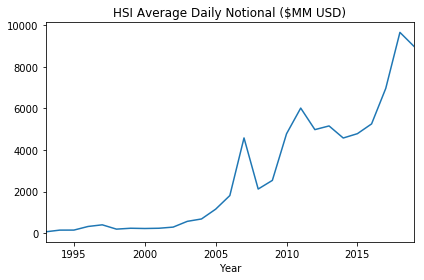

In [2]:
main('HSI')

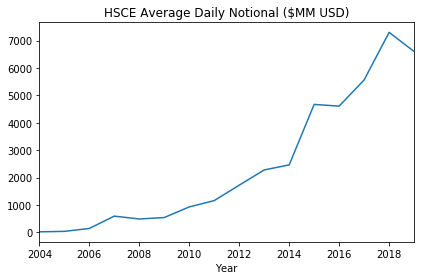

In [3]:
main('hsce')